In [ ]:
import numpy,os,sklearn
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.model_selection as sms
import pydicom as dicom

import utils

# Image Data

## Suspicious Mammographies (BCDR-D01 & BCDR-D02)

### CSV Analysis

In [ ]:
bcdr1_raw = pd.read_csv('d:/BCDR/BCDR-D01_dataset/bcdr_d01_img.csv')
bcdr1_raw = bcdr1_raw.drop_duplicates(subset=['image_filename'],keep='first',ignore_index=True)
bcdr1_raw= utils.fix_view(bcdr1_raw,'image_type_name')
bcdr1_features_raw = pd.read_csv('D:\BCDR\BCDR-D01_dataset/bcdr_d01_features.csv')
bcdr2_raw = pd.read_csv('d:/BCDR/BCDR-D02_dataset/bcdr_d02_img.csv')
bcdr2_raw = bcdr2_raw.drop_duplicates(subset=['image_filename'],keep='first',ignore_index=True)
bcdr2_raw= utils.fix_view(bcdr2_raw,'image_type_name')
bcdr2_features_raw = pd.read_csv('D:\BCDR\BCDR-D02_dataset/bcdr_d02_features.csv')
l1 = utils.lesion_findings(bcdr1_features_raw)
l2 = utils.lesion_findings(bcdr2_features_raw)

In [ ]:
bcdr1 = bcdr1_raw[['patient_id','study_id','image_filename','image_type_name','density','age']]
bcdr1_features= bcdr1_features_raw[['patient_id','study_id','image_view','s_x_center_mass','s_y_center_mass','density','age']]

bcdr1 = utils.merge_csv(bcdr1_features,bcdr1)
bcdr1['lesion_type'] = l1

In [ ]:
bcdr2 = bcdr2_raw[['patient_id','study_id','image_filename','image_type_name','density','age']]
bcdr2_features= bcdr2_features_raw[['patient_id','study_id','image_view','s_x_center_mass','s_y_center_mass','density','age']]

bcdr2 = utils.merge_csv(bcdr2_features,bcdr2)
bcdr2['lesion_type'] = l2

In [ ]:
lesion_mammographies1 = pd.DataFrame({})
lesion_mammographies1[['patient_id','image_view','image_path','x_center','y_center','density','age','lesion_type']] = bcdr1[['patient_id','image_view','image_filename','s_x_center_mass','s_y_center_mass','density','age','lesion_type']]
new_patients = []
for patient in list(lesion_mammographies1['patient_id']):
    patient_n= '1d'+str(patient)
    new_patients.append(patient_n)
lesion_mammographies1['patient_id'] = new_patients
lesion_mammographies1 = utils.fix_bcdr1_path(lesion_mammographies1,'image_path')

In [ ]:
lesion_mammographies2 = pd.DataFrame({})
lesion_mammographies2[['patient_id','image_view','image_path','x_center','y_center','density','age','lesion_type']] = bcdr2[['patient_id','image_view','image_filename','s_x_center_mass','s_y_center_mass','density','age','lesion_type']]
new_patients = []
for patient in list(lesion_mammographies2['patient_id']):
    patient_n= '2d'+str(patient)
    new_patients.append(patient_n)
lesion_mammographies2['patient_id'] = new_patients
lesion_mammographies2 = utils.fix_bcdr2_path(lesion_mammographies2,'image_path')
lesion_mammographies2 = lesion_mammographies2[:100]

In [ ]:
lesion_mammographies = pd.concat([lesion_mammographies1,lesion_mammographies2],ignore_index=True)
lesion_mammographies = utils.fix_view_back(lesion_mammographies,'image_view')
print('Suspicious Dataset: ',lesion_mammographies.shape)

### Split and Copy

In [ ]:
sus_training,sus_validation = sms.train_test_split(lesion_mammographies,test_size=0.35)

In [ ]:
utils.image_mover(sus_training,'image_data/raw/training/suspicious')
utils.image_mover(sus_validation,'image_data/raw/validation/suspicious')

## Normal Mammographies (BCDR-DN01 & INbreast)

### CSV Analysis

In [ ]:
bcdrN = pd.read_csv('d:/BCDR/BCDR-DN01_dataset/bcdr_dn01_img.csv')

In [ ]:
normal_mammographies1 = pd.DataFrame({})
normal_mammographies1[['patient_id','image_view','image_path','density','age']] = bcdrN[['patient_id','image_type_name','image_filename','density','age']]
normal_mammographies1 = utils.fix_bcdrN_path(normal_mammographies1,'image_path')

In [ ]:
xls_raw = pd.read_excel('D:/INBreast/INbreast.xls')
xls = pd.DataFrame()
xls['image_view'] = [xls_raw['Laterality'][i] + xls_raw['View'][i] for i in xls_raw.index] 
xls[['filename','finding notes']] = xls_raw[['File Name','Findings Notes (in Portuguese)']]

In [ ]:
path_list = os.listdir('D:/INBreast/AllDICOMs/')
r = []
for path in path_list:
    if path[-3:] != 'dcm':
        r.append(path)
for i in r:
    path_list.remove(i)

In [ ]:
patients = []
file_paths = []
image_views = []
for path in path_list:
    l = path.split('_')
    if len(l) > 1:
        patients.append(l[1])
        file_paths.append(path)
        image_views.append(l[3]+l[4])
images_df = pd.DataFrame({'patient_id':patients,'image_view':image_views,'image_path':file_paths})
images_df = utils.fix_inbreast_path(images_df,'image_path')

In [ ]:
images_df[['finding notes']] = xls[['finding notes']]
normal_df = images_df[images_df['finding notes'] == 'normal']
normal_mammographies2 = pd.DataFrame()
normal_mammographies2[['patient_id','image_view','image_path']] = normal_df[['patient_id','image_view','image_path']]

In [ ]:
normal_mammographies = pd.concat([normal_mammographies1,normal_mammographies2],ignore_index=True)
print('Normal Dataset: ',normal_mammographies.shape)

### Split and Copy

In [ ]:
normal_training,normal_validation = sms.train_test_split(normal_mammographies,test_size=0.35)

In [ ]:
utils.image_mover(normal_training,'image_data/raw/training/normal')
utils.image_mover(normal_validation,'image_data/raw/validation/normal')

In [ ]:
medical_image = dicom.read_file(list(normal_mammographies2['image_path'])[0])

In [ ]:
image = medical_image.pixel_array
plt.imshow(image,cmap='gray')

In [ ]:
hu_image = transform_to_hu(medical_image,image)
plt.imshow(hu_image)

In [ ]:
brain_image = window_image(hu_image, 60, 100)
plt.imshow(brain_image,cmap='gray')

In [ ]:
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

def transform_to_hu(medical_image, image):
    intercept = -1024
    slope = 1
    hu_image = image * slope + intercept

    return hu_image

## Age

In [ ]:
dfs = pd.concat([normal_mammographies,lesion_mammographies],ignore_index=True)

In [ ]:
a = 'numerical_data/features_training_suspicious.csv'
gt = pd.read_csv('image_data/csvs/training_suspicious.csv')
features_df = pd.read_csv(a)
ages = []
for i in gt.index:
    p = gt.loc[i,'Original']
    age_index = dfs[dfs['image_path'] == p].index
    age = dfs.loc[age_index,'age'].to_list()[0]
    ages.append(age)

In [ ]:
features_df['Age'] = ages
features_df.to_csv(a)

# Numerical Data

## Create Features Documents

In [ ]:
utils.mammary_features('image_data/raw/training/normal/','features_training_normal.csv')
utils.mammary_features('image_data/raw/training/suspicious/','features_training_suspicious.csv')
utils.mammary_features('image_data/raw/validation/normal/','features_validation_normal.csv')
utils.mammary_features('image_data/raw/validation/suspicious/','features_validation_suspicious.csv')

## Load Features Documents

In [ ]:
features_training_normal = pd.read_csv('numerical_data/features_training_normal.csv')
features_training_suspicious = pd.read_csv('numerical_data/features_training_suspicious.csv')
features_validation_normal = pd.read_csv('numerical_data/features_validation_normal.csv')
features_validation_suspicious = pd.read_csv('numerical_data/features_validation_suspicious.csv')

# Train Bird's Eye Model

## Crop Background and Downsample

In [ ]:
utils.downsample('image_data/raw/training/normal/','image_data/downsampled/training/normal/',1500,1100)
utils.downsample('image_data/raw/training/suspicious/','image_data/downsampled/training/suspicious/',1500,1100)
utils.downsample('image_data/raw/validation/normal/','image_data/downsampled/validation/normal/',1500,1100)
utils.downsample('image_data/raw/validation/suspicious/','image_data/downsampled/validation/suspicious/',1500,1100)

## Transfer Learning

In [ ]:
data_augmentation = True
shuffle = True

training_gen,validation_gen = utils.generator_transfer(1500,1100,data_augmentation,shuffle)

In [ ]:
model = utils.create_trans_model(1500,1100)
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['binary_accuracy','AUC'])

In [ ]:
model.fit(
    training_gen,
    epochs=25,
    validation_data=validation_gen)

In [ ]:
#model = keras.models.load_model('transfer.h5')

In [ ]:
data = utils.generator_transfer(1000,800,True,False)
y_true = data[1].classes
y_pred = model.predict(data[1],data[1].samples//12+1)
predictions_image = []
for i in y_pred:
    if i[0] > 0.5:
        predictions_image.append(1)
    else:
        predictions_image.append(0)

In [ ]:
c = sklearn.metrics.confusion_matrix(y_true,predictions_image)
sens = c[1][1]/(c[1][1]+c[1][0])
spec = c[0][0]/(c[0][0]+c[0][1])
print(c)
print('Sensitivity:',sens)
print('Specificity:',spec)

In [ ]:
auc = sklearn.metrics.roc_auc_score(y_true,y_pred)
fpr,tpr,_= sklearn.metrics.roc_curve(y_true,y_pred)
plt.plot(fpr,tpr)
print('AUC:',auc)

In [ ]:
model.save('birds_eye.h5')

## From-Scratch

In [ ]:
data_augmentation = True
shuffle = True

training_gen,validation_gen = utils.generator_transfer(1000,800,data_augmentation,shuffle)

In [ ]:
model = utils.create_fs_model(1000,800)
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['binary_accuracy','AUC'])

In [ ]:
model.fit(
    training_gen,
    epochs=25,
    validation_data=validation_gen)

In [ ]:
model = keras.models.load_model('from_scratch.h5')

In [ ]:
data = utils.generator_scratch(1000,800,True,False)
y_true = data[1].classes
y_pred = model.predict(data[1],data[1].samples//12+1)
predictions_image = []
for i in y_pred:
    if i[0] > 0.5:
        predictions_image.append(1)
    else:
        predictions_image.append(0)

In [ ]:
c = sklearn.metrics.confusion_matrix(y_true,predictions_image)
sens = c[1][1]/(c[1][1]+c[1][0])
spec = c[0][0]/(c[0][0]+c[0][1])
print(c)
print('Sensitivity:',sens)
print('Specificity:',spec)

In [ ]:
auc = sklearn.metrics.roc_auc_score(y_true,y_pred)
fpr,tpr,_= sklearn.metrics.roc_curve(y_true,y_pred)
plt.plot(fpr,tpr)
print('AUC:',auc)

# Train Negatives Model

## Copy Negatives

In [ ]:
downsample = True

utils.copy_negatives('image_data/downsampled/training/normal/',downsample)
utils.copy_negatives('image_data/downsampled/training/suspicious/',downsample)
utils.copy_negatives('image_data/downsampled/validation/normal/',downsample)
utils.copy_negatives('image_data/downsampled/validation/suspicious/',downsample)

## Transfer Learning

In [ ]:
data_augmentation = True
shuffle = True

training_gen,validation_gen = utils.generator_negatives(1000,800,data_augmentation,shuffle)

In [ ]:
model = utils.create_trans_model(1000,800)
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['binary_accuracy','AUC'])

In [ ]:
model.fit(
    training_gen,
    epochs=25,
    validation_data=validation_gen)

In [ ]:
data = utils.generator_transfer(1000,800,True,False)
y_true = data[1].classes
y_pred = model.predict(data[1],data[1].samples//12+1)
predictions_image = []
for i in y_pred:
    if i[0] > 0.5:
        predictions_image.append(1)
    else:
        predictions_image.append(0)

In [ ]:
model.save('negatives_model.h5')

# Train Quadrants Model

## Quadrants Segmentation

In [ ]:
utils.copy_quadrants('image_data/raw/training/normal/')
utils.copy_quadrants('image_data/downsampled/training/suspicious/')
utils.copy_quadrants('image_data/downsampled/validation/normal/')
utils.copy_quadrants('image_data/downsampled/validation/suspicious/')

### Data Augmentation

In [ ]:
a1 = utils.augment(370,550,'image_data/quadrant_1/CC/training/normal/')
a2 = utils.augment(500,600,'image_data/quadrant_2/CC/training/normal/')
a3 = utils.augment(370,550,'image_data/quadrant_3/CC/training/normal/')
a4 = utils.augment(400,450,'image_data/quadrant_1/MLO/training/normal/')
a5 = utils.augment(600,500,'image_data/quadrant_2/MLO/training/normal/')
a6 = utils.augment(400,500,'image_data/quadrant_3/MLO/training/normal/')
a7 = utils.augment(370,550,'image_data/quadrant_1/CC/training/suspicious/')
a8 = utils.augment(500,600,'image_data/quadrant_2/CC/training/suspicious/')
a9 = utils.augment(370,550,'image_data/quadrant_3/CC/training/suspicious/')
a10 = utils.augment(400,450,'image_data/quadrant_1/MLO/training/suspicious/')
a11 = utils.augment(600,500,'image_data/quadrant_2/MLO/training/suspicious/')
a12 = utils.augment(400,500,'image_data/quadrant_3/MLO/training/suspicious/')
a13 = utils.augment(370,550,'image_data/quadrant_1/CC/validation/normal/')
a14 = utils.augment(500,600,'image_data/quadrant_2/CC/validation/normal/')
a15 = utils.augment(370,550,'image_data/quadrant_3/CC/validation/normal/')
a16 = utils.augment(400,450,'image_data/quadrant_1/MLO/validation/normal/')
a17 = utils.augment(600,500,'image_data/quadrant_2/MLO/validation/normal/')
a18 = utils.augment(400,500,'image_data/quadrant_3/MLO/validation/normal/')
a19 = utils.augment(370,550,'image_data/quadrant_1/CC/validation/suspicious/')
a20 = utils.augment(500,600,'image_data/quadrant_2/CC/validation/suspicious/')
a21 = utils.augment(370,550,'image_data/quadrant_3/CC/validation/suspicious/')
a22 = utils.augment(400,450,'image_data/quadrant_1/MLO/validation/suspicious/')
a23 = utils.augment(600,500,'image_data/quadrant_2/MLO/validation/suspicious/')
a24 = utils.augment(400,500,'image_data/quadrant_3/MLO/validation/suspicious/')

for gen in [a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20,a21,a22,a23,a24]:
    for i in range(len(gen)):
        gen[i]

## Transfer Learning (Q1)

### CC View

In [ ]:
shuffle = True

training_gen,validation_gen = utils.generator_q1(370,550,'CC',shuffle)

In [ ]:
model = utils.create_trans_model(370,550)
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['binary_accuracy','AUC'])

In [ ]:
h = model.fit(
    training_gen,
    epochs=25,
    validation_data=validation_gen)

In [ ]:
model = keras.models.load_model('models/quadrants/Q1_CC_model.h5')

In [ ]:
data = utils.generator_q1(370,550,'CC',False)
y_true = data[1].classes
y_pred = model.predict(data[1],data[1].samples//12+1)
predictions_image = []
for i in y_pred:
    if i[0] > 0.5:
        predictions_image.append(1)
    else:
        predictions_image.append(0)

In [ ]:
c = sklearn.metrics.confusion_matrix(y_true,predictions_image)
sens = c[1][1]/(c[1][1]+c[1][0])
spec = c[0][0]/(c[0][0]+c[0][1])
print(c)
print('Sensitivity:',sens)
print('Specificity:',spec)

In [ ]:
auc = sklearn.metrics.roc_auc_score(y_true,y_pred)
fpr,tpr,_= sklearn.metrics.roc_curve(y_true,y_pred)
plt.plot(fpr,tpr)
print('AUC:',auc)

In [ ]:
model.save('models/quadrants/Q1_CC_model.h5')

### MLO View

In [ ]:
shuffle = True

training_gen,validation_gen = utils.generator_q1(400,450,'MLO',shuffle)

In [ ]:
model = utils.create_trans_model(400,450)
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['binary_accuracy','AUC'])

In [ ]:
model.fit(
    training_gen,
    epochs=15,
    validation_data=validation_gen)

In [ ]:
model = keras.models.load_model('models/quadrants/Q1_MLO_model.h5')

In [ ]:
data = utils.generator_q1(400,450,'MLO',False)
y_true = data[1].classes
y_pred = model.predict(data[1],data[1].samples//12+1)
predictions_image = []
for i in y_pred:
    if i[0] > 0.5:
        predictions_image.append(1)
    else:
        predictions_image.append(0)

In [ ]:
c = sklearn.metrics.confusion_matrix(y_true,predictions_image)
sens = c[1][1]/(c[1][1]+c[1][0])
spec = c[0][0]/(c[0][0]+c[0][1])
print(c)
print('Sensitivity:',sens)
print('Specificity:',spec)

In [ ]:
auc = sklearn.metrics.roc_auc_score(y_true,y_pred)
fpr,tpr,_= sklearn.metrics.roc_curve(y_true,y_pred)
plt.plot(fpr,tpr)
print('AUC:',auc)

In [ ]:
model.save('models/quadrants/Q1_MLO_model.h5')

### Both

In [ ]:
shuffle = True

training_gen,validation_gen = utils.generator_q1(400,550,'both',shuffle)

In [ ]:
model = utils.create_trans_model(400,550)
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['binary_accuracy','AUC'])

In [ ]:
model.fit(
    training_gen,
    epochs=15,
    validation_data=validation_gen)

In [ ]:
model.save('models/quadrants/Q1_model.h5')

In [ ]:
model = keras.models.load_model('models/quadrants/Q1_model.h5')

In [ ]:
data = utils.generator_q1(400,550,'both',False)
y_true = data[1].classes
y_pred = model.predict(data[1],data[1].samples//12+1)
predictions_image = []
for i in y_pred:
    if i[0] > 0.5:
        predictions_image.append(1)
    else:
        predictions_image.append(0)

In [ ]:
c = sklearn.metrics.confusion_matrix(y_true,predictions_image)
sens = c[1][1]/(c[1][1]+c[1][0])
spec = c[0][0]/(c[0][0]+c[0][1])
print(c)
print('Sensitivity:',sens)
print('Specificity:',spec)

In [ ]:
auc = sklearn.metrics.roc_auc_score(y_true,y_pred)
fpr,tpr,_= sklearn.metrics.roc_curve(y_true,y_pred)
plt.plot(fpr,tpr)
print('AUC:',auc)

## Transfer Learning (Q2)

### CC View

In [ ]:
shuffle = True

training_gen,validation_gen = utils.generator_q2(500,600,'CC',shuffle)

In [ ]:
model = utils.create_trans_model(500,600)
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['binary_accuracy','AUC'])

In [ ]:
model.fit(
    training_gen,
    epochs=25,
    validation_data=validation_gen)

In [ ]:
data = utils.generator_q2(500,600,'CC',shuffle)
y_true = data[1].classes
y_pred = model.predict(data[1],data[1].samples//12+1)
predictions_image = []
for i in y_pred:
    if i[0] > 0.5:
        predictions_image.append(1)
    else:
        predictions_image.append(0)

In [ ]:
c = sklearn.metrics.confusion_matrix(y_true,predictions_image)
sens = c[1][1]/(c[1][1]+c[1][0])
spec = c[0][0]/(c[0][0]+c[0][1])
print(c)
print('Sensitivity:',sens)
print('Specificity:',spec)

In [ ]:
auc = sklearn.metrics.roc_auc_score(y_true,y_pred)
fpr,tpr,_= sklearn.metrics.roc_curve(y_true,y_pred)
plt.plot(fpr,tpr)
print('AUC:',auc)

In [ ]:
model.save('models/quadrants/Q2_CC_model.h5')

### MLO View

In [ ]:
shuffle = True

training_gen,validation_gen = utils.generator_q2(600,500,'MLO',shuffle)

In [ ]:
model = utils.create_trans_model(600,500)
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['binary_accuracy','AUC'])

In [ ]:
model.fit(
    training_gen,
    epochs=25,
    validation_data=validation_gen)

In [ ]:
data = utils.generator_q2(600,500,'MLO',shuffle)
y_true = data[1].classes
y_pred = model.predict(data[1],data[1].samples//12+1)
predictions_image = []
for i in y_pred:
    if i[0] > 0.5:
        predictions_image.append(1)
    else:
        predictions_image.append(0)

In [ ]:
c = sklearn.metrics.confusion_matrix(y_true,predictions_image)
sens = c[1][1]/(c[1][1]+c[1][0])
spec = c[0][0]/(c[0][0]+c[0][1])
print(c)
print('Sensitivity:',sens)
print('Specificity:',spec)

In [ ]:
auc = sklearn.metrics.roc_auc_score(y_true,y_pred)
fpr,tpr,_= sklearn.metrics.roc_curve(y_true,y_pred)
plt.plot(fpr,tpr)
print('AUC:',auc)

In [ ]:
model.save('models/quadrants/Q2_MLO_model.h5')

## Transfer Learning (Q3)

### CC View

In [ ]:
shuffle = True

training_gen,validation_gen = utils.generator_q3(370,550,'CC',shuffle)

In [ ]:
model = utils.create_trans_model(370,550)
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['binary_accuracy','AUC'])

In [ ]:
model.fit(
    training_gen,
    epochs=25,
    validation_data=validation_gen)

In [ ]:
data = utils.generator_q3(370,550,'CC',shuffle)
y_true = data[1].classes
y_pred = model.predict(data[1],data[1].samples//12+1)
predictions_image = []
for i in y_pred:
    if i[0] > 0.5:
        predictions_image.append(1)
    else:
        predictions_image.append(0)

In [ ]:
c = sklearn.metrics.confusion_matrix(y_true,predictions_image)
sens = c[1][1]/(c[1][1]+c[1][0])
spec = c[0][0]/(c[0][0]+c[0][1])
print(c)
print('Sensitivity:',sens)
print('Specificity:',spec)

In [ ]:
auc = sklearn.metrics.roc_auc_score(y_true,y_pred)
fpr,tpr,_= sklearn.metrics.roc_curve(y_true,y_pred)
plt.plot(fpr,tpr)
print('AUC:',auc)

In [ ]:
model.save('models/quadrants/Q3_CC_model.h5')

### MLO View

In [ ]:
shuffle = True

training_gen,validation_gen = utils.generator_q3(400,500,'MLO',shuffle)

In [ ]:
model = utils.create_trans_model(400,500)
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['binary_accuracy','AUC'])

In [ ]:
model.fit(
    training_gen,
    epochs=25,
    validation_data=validation_gen)

In [ ]:
data = utils.generator_q3(400,500,'MLO',shuffle)
y_true = data[1].classes
y_pred = model.predict(data[1],data[1].samples//12+1)
predictions_image = []
for i in y_pred:
    if i[0] > 0.5:
        predictions_image.append(1)
    else:
        predictions_image.append(0)

In [ ]:
c = sklearn.metrics.confusion_matrix(y_true,predictions_image)
sens = c[1][1]/(c[1][1]+c[1][0])
spec = c[0][0]/(c[0][0]+c[0][1])
print(c)
print('Sensitivity:',sens)
print('Specificity:',spec)

In [ ]:
auc = sklearn.metrics.roc_auc_score(y_true,y_pred)
fpr,tpr,_= sklearn.metrics.roc_curve(y_true,y_pred)
plt.plot(fpr,tpr)
print('AUC:',auc)

In [ ]:
model.save('models/quadrants/Q3_MLO_model.h5')

# Patching

In [ ]:
#utils.save_patches_by_image('image_data/raw/training/normal/',300,0.2)
utils.save_patches_by_image('image_data/raw/training/suspicious/',300,0.2)
#utils.save_patches_by_image('image_data/raw/validation/normal/',300,0.2)
#utils.save_patches_by_image('image_data/raw/validation/suspicious/',300,0.2)

In [ ]:
#utils.classify_patches('image_data/raw/training/normal/')
utils.classify_patches('image_data/raw/training/suspicious/')
#utils.classify_patches('image_data/raw/validation/normal/')
#utils.classify_patches('image_data/raw/validation/suspicious/')


In [ ]:
#utils.add_to_features_csv('image_data/raw/training/normal/','numerical_data/features_training_normal.csv',0.4)
#utils.add_to_features_csv('image_data/raw/training/suspicious/','numerical_data/features_training_suspicious.csv',0.4)
#utils.add_to_features_csv('image_data/raw/validation/normal/','numerical_data/features_validation_normal.csv',0.4)
utils.add_to_features_csv('image_data/raw/validation/suspicious/','numerical_data/features_validation_suspicious.csv',0.4)

# Meta Classification

## Evaluate Mammograms

In [ ]:
features_validation_normal['Ground Truth'] = 0
features_validation_suspicious['Ground Truth'] = 1

In [ ]:
dataframe = pd.concat([features_validation_normal,features_validation_suspicious],ignore_index=True)

In [ ]:
model = keras.models.load_model('models/mammo_comp.h5')

In [ ]:
utils.classify_mammograms(model,dataframe,True)

## CNN Results

In [ ]:
comp = True

In [ ]:
if comp:
    dataframe = pd.read_csv('numerical_data/classification_data_comp.csv')
else:
    dataframe = pd.read_csv('numerical_data/classification_data.csv')

In [ ]:
data= utils.generator_transfer(1500,1100,False,False)
y_true = data[1].classes
y_pred = dataframe['Classifications']

In [ ]:
c = sklearn.metrics.confusion_matrix(y_true,numpy.round(y_pred))
sens = c[1][1]/(c[1][1]+c[1][0])
spec = c[0][0]/(c[0][0]+c[0][1])
print(c)
print('Sensitivity:',sens)
print('Specificity:',spec)

In [ ]:
acc = sklearn.metrics.accuracy_score(y_true,numpy.round(y_pred))
print('Accuracy:',acc)

In [ ]:
auc = sklearn.metrics.roc_auc_score(y_true,y_pred)
fpr,tpr,_= sklearn.metrics.roc_curve(y_true,y_pred)
plt.plot(fpr,tpr)
print('AUC:',auc)

## Metaclassifier

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

In [41]:
comp = True

In [42]:
if comp:
    dataframe = pd.read_csv('numerical_data/classification_data_comp.csv')
else:
    dataframe = pd.read_csv('numerical_data/classification_data.csv')
dataframe = dataframe.sample(n=len(dataframe.index))

In [43]:
X = dataframe.loc[:, dataframe.columns != 'Ground Truth']
X = X.loc[:, X.columns != 'Unnamed: 0']
X = X.loc[:, X.columns != 'Unnamed: 0.1']
X = X.loc[:, X.columns != 'Ratio']
#X = X.loc[:, X.columns != 'Ratios']
#X = X.loc[:, X.columns != 'I_Kurtosis']
#X = X.loc[:, X.columns != 'I_Mode']
#X = X.loc[:, X.columns != 'I_Std']
#X = X.loc[:, X.columns != 'I_Median']
#X = X.loc[:, X.columns != 'T_Entropy']
#X = X.loc[:, X.columns != 'I_Skewness']
y = dataframe['Ground Truth']

In [44]:
my_imputer = SimpleImputer(strategy='constant',fill_value=56)
imputed_X_train_age = my_imputer.fit_transform(numpy.array(X['Age']).reshape(-1,1))
X['Age'] = imputed_X_train_age
X = X.astype({'Age': 'int32'})

In [45]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=0.35)
X.head(5)

,I_Mean,I_Std,I_Median,I_Mode,T_Entropy,I_Skewness,I_Kurtosis,Age,Classifications,Ratios
64,138.79672,45.44520,134.0,97,4.96730,0.00176,-0.88518,41,0.001,0.03
16,113.02930,33.82095,116.0,113,4.72211,-0.13892,0.26601,41,0.014,0.01
150,129.04316,31.48155,134.0,131,4.67304,-0.42463,0.69313,58,0.998,0.11
151,90.26912,40.22491,89.0,89,4.89887,0.39204,0.21098,60,0.980,0.06
54,119.88714,44.94759,105.0,97,4.80965,0.85700,0.15188,41,0.033,0.16


In [49]:
forest_model = RandomForestClassifier()
model = svm.SVC()
pipeline = Pipeline(steps=[('model',model)])
pipeline = Pipeline(steps=[('model',forest_model)])
pipeline.fit(X_train,y_train)
preds = pipeline.predict(X_valid)
names = ['normal','suspicious']
print(classification_report(y_valid, preds,target_names=names))

              precision    recall  f1-score   support

      normal       0.93      0.82      0.87        34
  suspicious       0.81      0.93      0.87        28

    accuracy                           0.87        62
   macro avg       0.87      0.88      0.87        62
weighted avg       0.88      0.87      0.87        62



### Feature Importance

<BarContainer object of 10 artists>

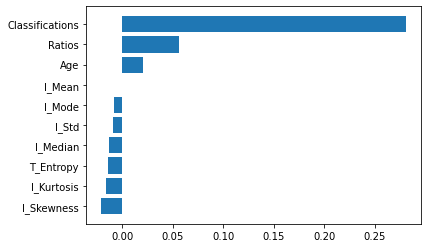

In [50]:
result = permutation_importance(forest_model, X_valid, y_valid, n_repeats=10)
sorted_idx = result.importances_mean.argsort()
plt.barh(X_train.columns[sorted_idx], result.importances_mean[sorted_idx])

In [51]:
X_new = SelectKBest(f_classif, k=5).fit_transform(X, y)

### Parameter Optimization

#### Random Forest

In [52]:
p = {'n_estimators':[50,100,500,1000,1500,2000],'max_depth':[3,4,5,6,7]}
c = GridSearchCV(forest_model,p,scoring='roc_auc')
c.fit(X,y)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'n_estimators': [50, 100, 500, 1000, 1500, 2000]},
             scoring='roc_auc')

In [53]:
c.best_estimator_

RandomForestClassifier(max_depth=7)

In [54]:
c.best_score_

0.9536310820624546

#### SVM

In [55]:
p = {'C':[0.5,0.75,1,1.25,1.5,1.75,2],'kernel':['linear','poly','sigmoid','rbf']}
c = GridSearchCV(model,p,scoring='roc_auc')
c.fit(X,y)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2],
                         'kernel': ['linear', 'poly', 'sigmoid', 'rbf']},
             scoring='roc_auc')

In [56]:
c.best_estimator_

SVC(C=0.5, kernel='linear')

In [57]:
c.best_score_

0.9067901234567902

In [ ]:
0/0

### Cross-validation (RF)

In [58]:
forest_model = RandomForestClassifier(max_depth=7)
pipeline = Pipeline(steps=[('model',forest_model)])
scores = cross_val_score(pipeline, X, y,cv=5,scoring='roc_auc')
print('Accuracies: \n',scores)

Accuracies: 
 [0.93518519 0.97712418 0.94117647 0.97058824 0.9379085 ]


In [59]:
acc = []
for n in range(100):
    forest_model = RandomForestClassifier(max_depth=7,random_state=n)
    pipeline = Pipeline(steps=[('model',forest_model)])
    scores = cross_val_score(pipeline, X, y,cv=5,scoring='roc_auc')
    acc.append(scores)

In [60]:
accs = []
for i in acc:
    accs.append(sum(i)/len(i))

In [61]:
a = pd.DataFrame({'With Patches':accs})
a.describe()

,With Patches
count,100.000000
mean,0.947751
std,0.003140
min,0.939579
25%,0.945198
50%,0.947876
75%,0.949728
max,0.954902


### Cross-Validation (SVM)

In [62]:
model = svm.SVC(C=0.5, kernel='linear')
pipeline = Pipeline(steps=[('model',model)])
scores = cross_val_score(pipeline, X, y,cv=5,scoring='roc_auc')
print('Accuracies: \n',scores)

Accuracies: 
 [0.86728395 1.         0.8627451  0.95424837 0.8496732 ]


In [63]:
acc = []
for n in range(100):
    model = svm.SVC(C=0.5, kernel='linear')
    pipeline = Pipeline(steps=[('model',model)])
    scores = cross_val_score(pipeline, X, y,cv=5,scoring='roc_auc')
    acc.append(scores)

In [64]:
accs = []
for i in acc:
    accs.append(sum(i)/len(i))

In [65]:
a = pd.DataFrame({'With Patches':accs})
a.describe()

,With Patches
count,100.00000
mean,0.90679
std,0.00000
min,0.90679
25%,0.90679
50%,0.90679
75%,0.90679
max,0.90679
